In [1]:
import warnings
warnings.filterwarnings("ignore")
import os,logging
logging.disable(logging.WARNING)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
# Workspace problem with several narrow gaps
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import os
import csv
from random import randint, random
import time
import pathlib
import cv2
config = tf.ConfigProto()
config.gpu_options.allow_growth=True

In [3]:
tf.test.is_gpu_available()

True

# Clarification
Due to the loading of the array in MATLAB is transposed, column wise and not row wise, the data generated is of the format ```(y_sample,x_sample,y_init,x_init)```
Therefore the needful must be done to properly visualise the sampled points.

In [4]:
STATE_DIM = 2  # state dimension x, y
VALS_PER_SAMPLE = 6  # number of numbers per training sample
SAMPLE_SCALE_UP = 160
MAP_NUM = 1  # which map training on
DATA_ROOT = './Training_Data'
MODEL_DIR = './Models/0'+str(MAP_NUM)
# Parse sampling data
samples_file = os.path.join(DATA_ROOT, 'nodes_{}.txt'.format(MAP_NUM))
with open(samples_file, 'r') as f:
  txt_rows = f.read().split("\n")
  data_list = []
  for row in txt_rows:
    new_data = []
    for val in row.split(" "):
      try:
        num = float(val)
        new_data.append(num)
      except ValueError:
        continue
    if len(new_data) == VALS_PER_SAMPLE:
      data_list.append(new_data)
    else:
      print("Error parsing a line: %s" % row)
sample_data = np.array(data_list,dtype='float')

# Load original map that was sampled from
orig_map_file = os.path.join(DATA_ROOT, 'map{}.npy'.format(MAP_NUM))
orig_map = np.load(orig_map_file)

# Parse mini map that was sampled from for training
mini_map_file = os.path.join(DATA_ROOT, 'map{}_mini.npy'.format(MAP_NUM))
map_data = np.load(mini_map_file)
print("Done!")




Error parsing a line: 
Done!


Network Hyperparameters

In [5]:
# neural network parameters
mb_size = 256  # mini batch GD size
h_Q_dim = 512
h_P_dim = 512
z_dim = 3 # latent
c = 0  # 
lr = 1e-4  # learning rate
state_weights = [[1, 1]]  # both states (x,y) are equally important
TRAIN_ITERS = 500000
ITERS_PER_SAVE = 10000

# split the inputs and conditions into test train (to be processed in the next step into an occupancy grid representation)
ratioTestTrain = 0.8
numEntries = sample_data.shape[0]
numTrain = int(numEntries*ratioTestTrain)
numTest = numEntries - numTrain

# x_train and x_test are the samples from solved paths
x_train = sample_data[:numTrain, :STATE_DIM] # state: row, col
x_test = sample_data[numTrain:, :STATE_DIM]  # other part of data

# cond_data 1D array of concatenated [init, goal, map]
unrolled_map = np.concatenate(map_data, axis=0)
COND_DIM = STATE_DIM + STATE_DIM + len(unrolled_map)  # init + goal + map
cond_data = np.zeros((numEntries, COND_DIM))
for r in range(numEntries):
  cond_data[r,:] = np.concatenate([sample_data[r,STATE_DIM:], unrolled_map], axis=0)

cond_train = cond_data[:numTrain, :]
cond_test = cond_data[numTrain:, :]

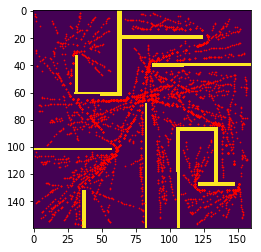

In [6]:
# Load original map that was sampled from and print any collisions
orig_map_file = os.path.join(DATA_ROOT, 'map{}.npy'.format(MAP_NUM))
orig_map = np.load(orig_map_file)
plt.imshow(orig_map)
plt.scatter(x=x_train[:,1]*SAMPLE_SCALE_UP, y=x_train[:,0]*SAMPLE_SCALE_UP, color="red", s=0.5,) # init
plt.show()
x=x_train[:,0]*SAMPLE_SCALE_UP
y=x_train[:,1]*SAMPLE_SCALE_UP
for i,j in zip(x_train[:,0],x_train[:,1]):
  if orig_map[int(i*SAMPLE_SCALE_UP),int(j*SAMPLE_SCALE_UP)]==1:
    print(i,j)
    print(i*SAMPLE_SCALE_UP,j*SAMPLE_SCALE_UP)

# Training
To rename output tensors ``` tf.identity(z, name="z")``` 

In [9]:
# define networks
X = tf.placeholder(tf.float32, shape=[None, STATE_DIM], name="X")
c = tf.placeholder(tf.float32, shape=[None, COND_DIM], name="c")

# Q (Encoder)
inputs_Q = tf.concat(axis=1, values=[X,c])

dense_Q1 = tf.layers.dense(inputs=inputs_Q, units=h_Q_dim, activation=tf.nn.relu)
dropout_Q1 = tf.layers.dropout(inputs=dense_Q1, rate=0.5)
dense_Q2 = tf.layers.dense(inputs=dropout_Q1, units=h_Q_dim, activation=tf.nn.relu)

z_mu = tf.layers.dense(inputs=dense_Q2, units=z_dim) # output here is z_mu
z_logvar = tf.layers.dense(inputs=dense_Q2, units=z_dim) # output here is z_logvar

# P (Reparameterisation tricks)
eps = tf.random_normal(shape=tf.shape(z_mu))
z = tf.add(z_mu, tf.exp(z_logvar / 2) * eps)
inputs_P = tf.concat(axis=1, values=[z,c])

# (Decoder)
dense_P1 = tf.layers.dense(inputs=inputs_P, units=h_P_dim, activation=tf.nn.relu)
dropout_P1 = tf.layers.dropout(inputs=dense_P1, rate=0.5)
dense_P2 = tf.layers.dense(inputs=dropout_P1, units=h_P_dim, activation=tf.nn.relu)

y = tf.layers.dense(inputs=dense_P2, units=STATE_DIM) # fix to also output y

# training
recon_loss = tf.losses.mean_squared_error(labels=X, predictions=y, weights=state_weights)
# TODO: fix loss function for angles going around
kl_loss = 10**-4 * 2 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1)

cvae_loss = tf.reduce_mean(kl_loss + recon_loss)

train_step = tf.train.AdamOptimizer(lr).minimize(cvae_loss)

sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())
tf.train.export_meta_graph(MODEL_DIR+'/graph.meta')
it = 0;

Iter: 0
Loss: 0.6191



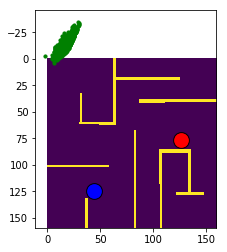

Iter: 1000
Loss: 0.01576

Iter: 2000
Loss: 0.002479

Iter: 3000
Loss: 0.002492

Iter: 4000
Loss: 0.002373

Iter: 5000
Loss: 0.002634

Iter: 6000
Loss: 0.002302

Iter: 7000
Loss: 0.002382

Iter: 8000
Loss: 0.002343

Iter: 9000
Loss: 0.002278

Iter: 10000
Loss: 0.002205



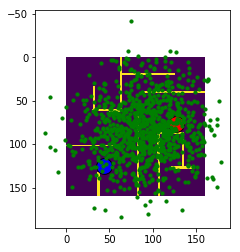

Iter: 11000
Loss: 0.00228

Iter: 12000
Loss: 0.002468

Iter: 13000
Loss: 0.002557

Iter: 14000
Loss: 0.002429

Iter: 15000
Loss: 0.002642

Iter: 16000
Loss: 0.002174

Iter: 17000
Loss: 0.002245

Iter: 18000
Loss: 0.002242

Iter: 19000
Loss: 0.002321

Iter: 20000
Loss: 0.002263



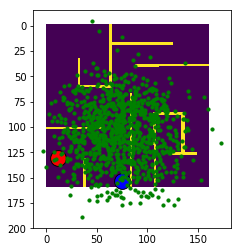

Iter: 21000
Loss: 0.00237

Iter: 22000
Loss: 0.002239

Iter: 23000
Loss: 0.002247

Iter: 24000
Loss: 0.002208

Iter: 25000
Loss: 0.00251

Iter: 26000
Loss: 0.002242

Iter: 27000
Loss: 0.002151

Iter: 28000
Loss: 0.002176

Iter: 29000
Loss: 0.002278

Iter: 30000
Loss: 0.002161



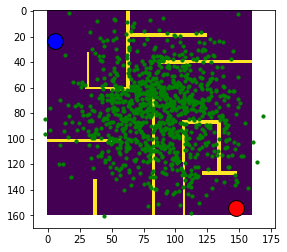

Iter: 31000
Loss: 0.002109

Iter: 32000
Loss: 0.002203

Iter: 33000
Loss: 0.002144

Iter: 34000
Loss: 0.002177

Iter: 35000
Loss: 0.00212

Iter: 36000
Loss: 0.002173

Iter: 37000
Loss: 0.002084

Iter: 38000
Loss: 0.00218

Iter: 39000
Loss: 0.002127

Iter: 40000
Loss: 0.002178



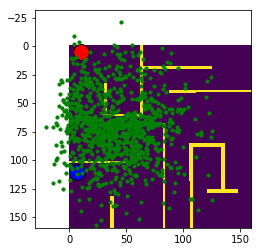

Iter: 41000
Loss: 0.002142

Iter: 42000
Loss: 0.002034

Iter: 43000
Loss: 0.002198

Iter: 44000
Loss: 0.002091

Iter: 45000
Loss: 0.002116

Iter: 46000
Loss: 0.002119

Iter: 47000
Loss: 0.002132

Iter: 48000
Loss: 0.00209

Iter: 49000
Loss: 0.002141

Iter: 50000
Loss: 0.002111



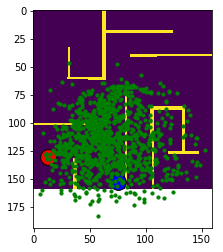

Iter: 51000
Loss: 0.002201

Iter: 52000
Loss: 0.001916

Iter: 53000
Loss: 0.002027

Iter: 54000
Loss: 0.002045

Iter: 55000
Loss: 0.002058

Iter: 56000
Loss: 0.002068

Iter: 57000
Loss: 0.001987

Iter: 58000
Loss: 0.002044

Iter: 59000
Loss: 0.001958

Iter: 60000
Loss: 0.002077



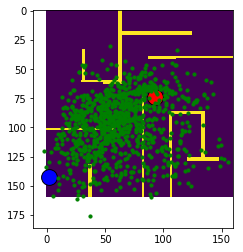

Iter: 61000
Loss: 0.002017

Iter: 62000
Loss: 0.001992

Iter: 63000
Loss: 0.002299

Iter: 64000
Loss: 0.001951

Iter: 65000
Loss: 0.002034

Iter: 66000
Loss: 0.002064

Iter: 67000
Loss: 0.001987

Iter: 68000
Loss: 0.001962

Iter: 69000
Loss: 0.002066

Iter: 70000
Loss: 0.002115



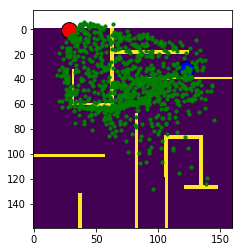

Iter: 71000
Loss: 0.001975

Iter: 72000
Loss: 0.002064

Iter: 73000
Loss: 0.002023

Iter: 74000
Loss: 0.002456

Iter: 75000
Loss: 0.002001

Iter: 76000
Loss: 0.001952

Iter: 77000
Loss: 0.001968

Iter: 78000
Loss: 0.00198

Iter: 79000
Loss: 0.002004

Iter: 80000
Loss: 0.001971



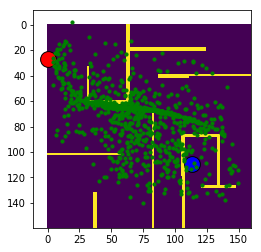

Iter: 81000
Loss: 0.002046

Iter: 82000
Loss: 0.001898

Iter: 83000
Loss: 0.001998

Iter: 84000
Loss: 0.001885

Iter: 85000
Loss: 0.001962

Iter: 86000
Loss: 0.00217

Iter: 87000
Loss: 0.001895

Iter: 88000
Loss: 0.002025

Iter: 89000
Loss: 0.001936

Iter: 90000
Loss: 0.001948



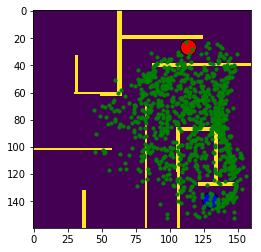

Iter: 91000
Loss: 0.00193

Iter: 92000
Loss: 0.001858

Iter: 93000
Loss: 0.001961

Iter: 94000
Loss: 0.002006

Iter: 95000
Loss: 0.001968

Iter: 96000
Loss: 0.001976

Iter: 97000
Loss: 0.001892

Iter: 98000
Loss: 0.001877

Iter: 99000
Loss: 0.001914

Iter: 100000
Loss: 0.001826



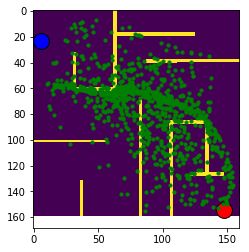

Iter: 101000
Loss: 0.001941

Iter: 102000
Loss: 0.001847

Iter: 103000
Loss: 0.001897

Iter: 104000
Loss: 0.001877

Iter: 105000
Loss: 0.001993

Iter: 106000
Loss: 0.001931

Iter: 107000
Loss: 0.00177

Iter: 108000
Loss: 0.001719

Iter: 109000
Loss: 0.001834

Iter: 110000
Loss: 0.001931



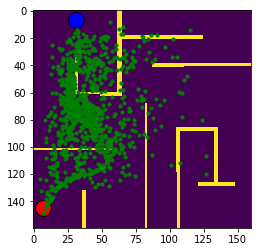

Iter: 111000
Loss: 0.001901

Iter: 112000
Loss: 0.001926

Iter: 113000
Loss: 0.001811

Iter: 114000
Loss: 0.001817

Iter: 115000
Loss: 0.001812

Iter: 116000
Loss: 0.00181

Iter: 117000
Loss: 0.001908

Iter: 118000
Loss: 0.001846

Iter: 119000
Loss: 0.001783

Iter: 120000
Loss: 0.001793



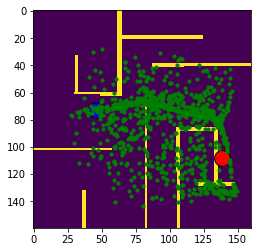

Iter: 121000
Loss: 0.001721

Iter: 122000
Loss: 0.001793

Iter: 123000
Loss: 0.001759

Iter: 124000
Loss: 0.001781

Iter: 125000
Loss: 0.0018

Iter: 126000
Loss: 0.001719

Iter: 127000
Loss: 0.001718

Iter: 128000
Loss: 0.001762

Iter: 129000
Loss: 0.001772

Iter: 130000
Loss: 0.001784



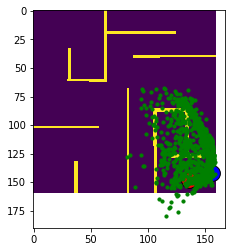

Iter: 131000
Loss: 0.001766

Iter: 132000
Loss: 0.001758

Iter: 133000
Loss: 0.001733

Iter: 134000
Loss: 0.001758

Iter: 135000
Loss: 0.001899

Iter: 136000
Loss: 0.001829

Iter: 137000
Loss: 0.001741

Iter: 138000
Loss: 0.001794

Iter: 139000
Loss: 0.001767

Iter: 140000
Loss: 0.001801



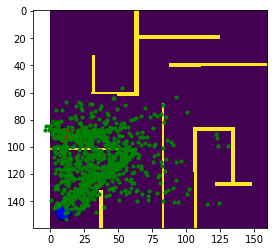

Iter: 141000
Loss: 0.001736

Iter: 142000
Loss: 0.001708

Iter: 143000
Loss: 0.001828

Iter: 144000
Loss: 0.001818

Iter: 145000
Loss: 0.001713

Iter: 146000
Loss: 0.001749

Iter: 147000
Loss: 0.001719

Iter: 148000
Loss: 0.001639

Iter: 149000
Loss: 0.001714

Iter: 150000
Loss: 0.001733



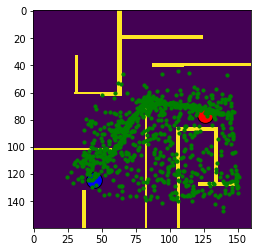

Iter: 151000
Loss: 0.001664

Iter: 152000
Loss: 0.001774

Iter: 153000
Loss: 0.001763

Iter: 154000
Loss: 0.001944

Iter: 155000
Loss: 0.001667

Iter: 156000
Loss: 0.001782

Iter: 157000
Loss: 0.00173

Iter: 158000
Loss: 0.001734

Iter: 159000
Loss: 0.001644

Iter: 160000
Loss: 0.00174



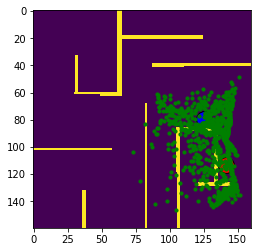

Iter: 161000
Loss: 0.001736

Iter: 162000
Loss: 0.001688

Iter: 163000
Loss: 0.001688

Iter: 164000
Loss: 0.001721

Iter: 165000
Loss: 0.001709

Iter: 166000
Loss: 0.001768

Iter: 167000
Loss: 0.001799

Iter: 168000
Loss: 0.001685

Iter: 169000
Loss: 0.001639

Iter: 170000
Loss: 0.00177



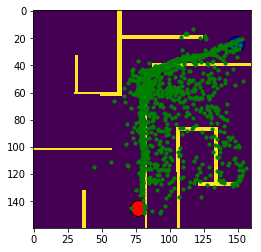

Iter: 171000
Loss: 0.001652

Iter: 172000
Loss: 0.001712

Iter: 173000
Loss: 0.001793

Iter: 174000
Loss: 0.001705

Iter: 175000
Loss: 0.001627

Iter: 176000
Loss: 0.001704

Iter: 177000
Loss: 0.001784

Iter: 178000
Loss: 0.001789

Iter: 179000
Loss: 0.001636

Iter: 180000
Loss: 0.001803



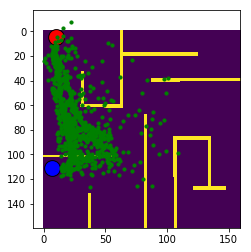

Iter: 181000
Loss: 0.001655

Iter: 182000
Loss: 0.001668

Iter: 183000
Loss: 0.001563

Iter: 184000
Loss: 0.001668

Iter: 185000
Loss: 0.00175

Iter: 186000
Loss: 0.001618

Iter: 187000
Loss: 0.001705

Iter: 188000
Loss: 0.001629

Iter: 189000
Loss: 0.001709

Iter: 190000
Loss: 0.001657



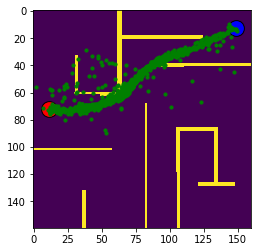

Iter: 191000
Loss: 0.001587

Iter: 192000
Loss: 0.001669

Iter: 193000
Loss: 0.001638

Iter: 194000
Loss: 0.00182

Iter: 195000
Loss: 0.001716

Iter: 196000
Loss: 0.001757

Iter: 197000
Loss: 0.001664

Iter: 198000
Loss: 0.001716

Iter: 199000
Loss: 0.001678

Iter: 200000
Loss: 0.001781



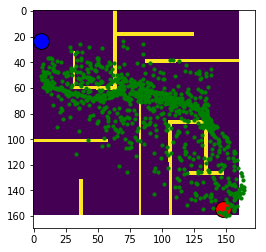

Iter: 201000
Loss: 0.001732

Iter: 202000
Loss: 0.001696

Iter: 203000
Loss: 0.001707

Iter: 204000
Loss: 0.001606

Iter: 205000
Loss: 0.001579

Iter: 206000
Loss: 0.001656

Iter: 207000
Loss: 0.00164

Iter: 208000
Loss: 0.001728

Iter: 209000
Loss: 0.001649

Iter: 210000
Loss: 0.001619



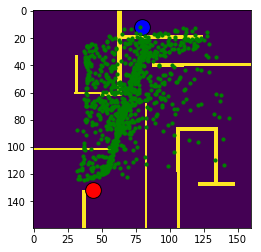

Iter: 211000
Loss: 0.001641

Iter: 212000
Loss: 0.001763

Iter: 213000
Loss: 0.001577

Iter: 214000
Loss: 0.00168

Iter: 215000
Loss: 0.001629

Iter: 216000
Loss: 0.001633

Iter: 217000
Loss: 0.001613

Iter: 218000
Loss: 0.001579

Iter: 219000
Loss: 0.001532

Iter: 220000
Loss: 0.001683



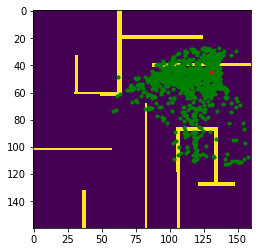

Iter: 221000
Loss: 0.001665

Iter: 222000
Loss: 0.00158

Iter: 223000
Loss: 0.001591

Iter: 224000
Loss: 0.001687

Iter: 225000
Loss: 0.001591

Iter: 226000
Loss: 0.001712

Iter: 227000
Loss: 0.001695

Iter: 228000
Loss: 0.001576

Iter: 229000
Loss: 0.001719

Iter: 230000
Loss: 0.001614



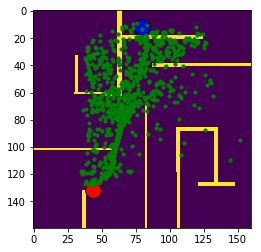

Iter: 231000
Loss: 0.001707

Iter: 232000
Loss: 0.001677

Iter: 233000
Loss: 0.001628

Iter: 234000
Loss: 0.00165

Iter: 235000
Loss: 0.001639

Iter: 236000
Loss: 0.001556

Iter: 237000
Loss: 0.00159

Iter: 238000
Loss: 0.001567

Iter: 239000
Loss: 0.001599

Iter: 240000
Loss: 0.001512



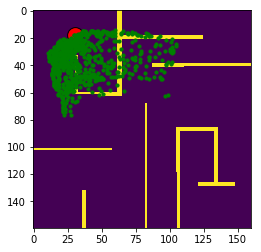

Iter: 241000
Loss: 0.001595

Iter: 242000
Loss: 0.001658

Iter: 243000
Loss: 0.001554

Iter: 244000
Loss: 0.001539

Iter: 245000
Loss: 0.001537

Iter: 246000
Loss: 0.001587

Iter: 247000
Loss: 0.001584

Iter: 248000
Loss: 0.001614

Iter: 249000
Loss: 0.001564

Iter: 250000
Loss: 0.001626



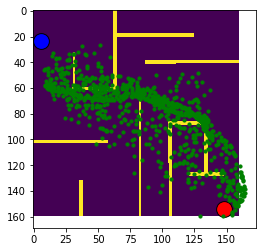

Iter: 251000
Loss: 0.001635

Iter: 252000
Loss: 0.001702

Iter: 253000
Loss: 0.00155

Iter: 254000
Loss: 0.001607

Iter: 255000
Loss: 0.001649

Iter: 256000
Loss: 0.001716

Iter: 257000
Loss: 0.001603

Iter: 258000
Loss: 0.001586

Iter: 259000
Loss: 0.00159

Iter: 260000
Loss: 0.00159



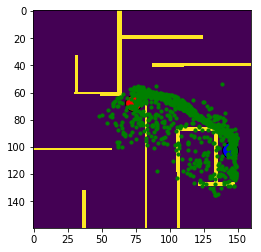

Iter: 261000
Loss: 0.001555

Iter: 262000
Loss: 0.001571

Iter: 263000
Loss: 0.001657

Iter: 264000
Loss: 0.001628

Iter: 265000
Loss: 0.001592

Iter: 266000
Loss: 0.00158

Iter: 267000
Loss: 0.001652

Iter: 268000
Loss: 0.001634

Iter: 269000
Loss: 0.001487

Iter: 270000
Loss: 0.001546



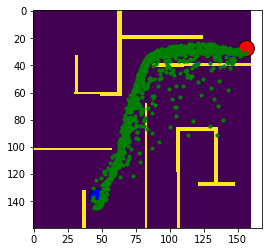

Iter: 271000
Loss: 0.001607

Iter: 272000
Loss: 0.001575

Iter: 273000
Loss: 0.001631

Iter: 274000
Loss: 0.001546

Iter: 275000
Loss: 0.00155

Iter: 276000
Loss: 0.001606

Iter: 277000
Loss: 0.001499

Iter: 278000
Loss: 0.001579

Iter: 279000
Loss: 0.001546

Iter: 280000
Loss: 0.001494



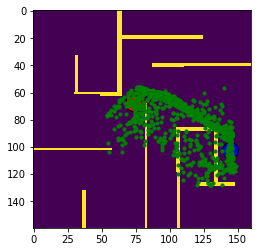

Iter: 281000
Loss: 0.001529

Iter: 282000
Loss: 0.001489

Iter: 283000
Loss: 0.001439

Iter: 284000
Loss: 0.001558

Iter: 285000
Loss: 0.001554

Iter: 286000
Loss: 0.001543

Iter: 287000
Loss: 0.001573

Iter: 288000
Loss: 0.001648

Iter: 289000
Loss: 0.00146

Iter: 290000
Loss: 0.001526



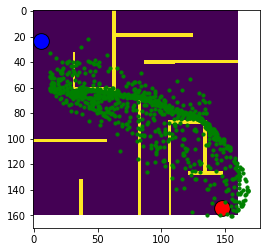

Iter: 291000
Loss: 0.001517

Iter: 292000
Loss: 0.001496

Iter: 293000
Loss: 0.001541

Iter: 294000
Loss: 0.0017

Iter: 295000
Loss: 0.001588

Iter: 296000
Loss: 0.001562

Iter: 297000
Loss: 0.001515

Iter: 298000
Loss: 0.001532

Iter: 299000
Loss: 0.00154

Iter: 300000
Loss: 0.001537



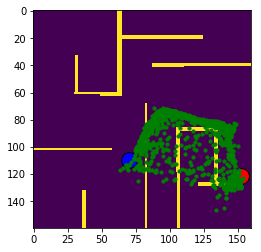

Iter: 301000
Loss: 0.00153

Iter: 302000
Loss: 0.001424

Iter: 303000
Loss: 0.001523

Iter: 304000
Loss: 0.001517

Iter: 305000
Loss: 0.001557

Iter: 306000
Loss: 0.001575

Iter: 307000
Loss: 0.001538

Iter: 308000
Loss: 0.001518

Iter: 309000
Loss: 0.001571

Iter: 310000
Loss: 0.001662



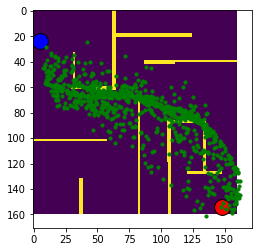

Iter: 311000
Loss: 0.001472

Iter: 312000
Loss: 0.00155

Iter: 313000
Loss: 0.001593

Iter: 314000
Loss: 0.001518

Iter: 315000
Loss: 0.001496

Iter: 316000
Loss: 0.001645

Iter: 317000
Loss: 0.001459

Iter: 318000
Loss: 0.001555

Iter: 319000
Loss: 0.001545

Iter: 320000
Loss: 0.001542



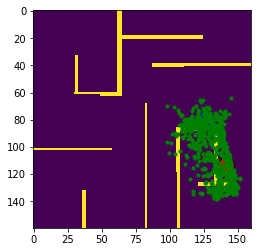

Iter: 321000
Loss: 0.001531

Iter: 322000
Loss: 0.001466

Iter: 323000
Loss: 0.001677

Iter: 324000
Loss: 0.00158

Iter: 325000
Loss: 0.001661

Iter: 326000
Loss: 0.001488

Iter: 327000
Loss: 0.001489

Iter: 328000
Loss: 0.001565

Iter: 329000
Loss: 0.001514

Iter: 330000
Loss: 0.001484



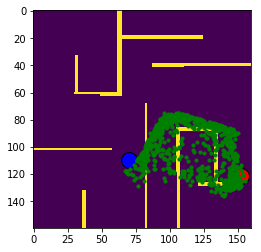

Iter: 331000
Loss: 0.001551

Iter: 332000
Loss: 0.001557

Iter: 333000
Loss: 0.001481

Iter: 334000
Loss: 0.001508

Iter: 335000
Loss: 0.001665

Iter: 336000
Loss: 0.001444

Iter: 337000
Loss: 0.001532

Iter: 338000
Loss: 0.001448

Iter: 339000
Loss: 0.001469

Iter: 340000
Loss: 0.001452



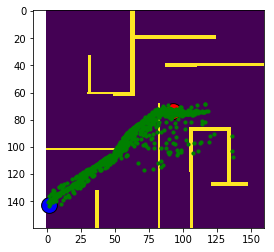

Iter: 341000
Loss: 0.001546

Iter: 342000
Loss: 0.001471

Iter: 343000
Loss: 0.001462

Iter: 344000
Loss: 0.001636

Iter: 345000
Loss: 0.001492

Iter: 346000
Loss: 0.001525

Iter: 347000
Loss: 0.001478

Iter: 348000
Loss: 0.001545

Iter: 349000
Loss: 0.001509

Iter: 350000
Loss: 0.001449



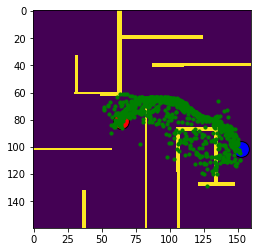

Iter: 351000
Loss: 0.001412

Iter: 352000
Loss: 0.001512

Iter: 353000
Loss: 0.001497

Iter: 354000
Loss: 0.001453

Iter: 355000
Loss: 0.001529

Iter: 356000
Loss: 0.001545

Iter: 357000
Loss: 0.001513

Iter: 358000
Loss: 0.001475

Iter: 359000
Loss: 0.001525

Iter: 360000
Loss: 0.001498



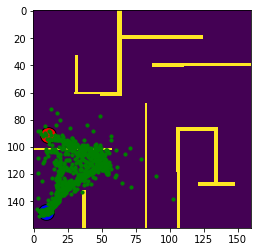

Iter: 361000
Loss: 0.001526

Iter: 362000
Loss: 0.001518

Iter: 363000
Loss: 0.001551

Iter: 364000
Loss: 0.001475

Iter: 365000
Loss: 0.00144

Iter: 366000
Loss: 0.001446

Iter: 367000
Loss: 0.001523

Iter: 368000
Loss: 0.001494

Iter: 369000
Loss: 0.001537

Iter: 370000
Loss: 0.00147



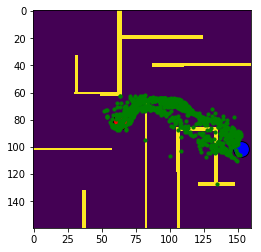

Iter: 371000
Loss: 0.001457

Iter: 372000
Loss: 0.001472

Iter: 373000
Loss: 0.001513

Iter: 374000
Loss: 0.001459

Iter: 375000
Loss: 0.00149

Iter: 376000
Loss: 0.001462

Iter: 377000
Loss: 0.001573

Iter: 378000
Loss: 0.001495

Iter: 379000
Loss: 0.001566

Iter: 380000
Loss: 0.001452



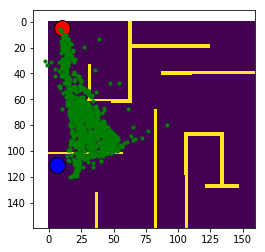

Iter: 381000
Loss: 0.001483

Iter: 382000
Loss: 0.00144

Iter: 383000
Loss: 0.001438

Iter: 384000
Loss: 0.001448

Iter: 385000
Loss: 0.001498

Iter: 386000
Loss: 0.001493

Iter: 387000
Loss: 0.001476

Iter: 388000
Loss: 0.001483

Iter: 389000
Loss: 0.001515

Iter: 390000
Loss: 0.001479



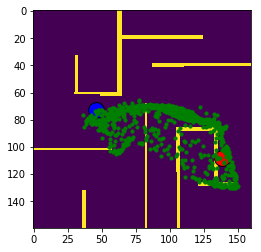

Iter: 391000
Loss: 0.00152

Iter: 392000
Loss: 0.00142

Iter: 393000
Loss: 0.001463

Iter: 394000
Loss: 0.00144

Iter: 395000
Loss: 0.001487

Iter: 396000
Loss: 0.001461

Iter: 397000
Loss: 0.001469

Iter: 398000
Loss: 0.001464

Iter: 399000
Loss: 0.00154

Iter: 400000
Loss: 0.001464



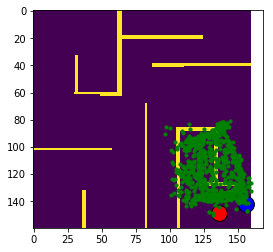

Iter: 401000
Loss: 0.001492

Iter: 402000
Loss: 0.001421

Iter: 403000
Loss: 0.001475

Iter: 404000
Loss: 0.001483

Iter: 405000
Loss: 0.001493

Iter: 406000
Loss: 0.001511

Iter: 407000
Loss: 0.001509

Iter: 408000
Loss: 0.001464

Iter: 409000
Loss: 0.001491

Iter: 410000
Loss: 0.001569



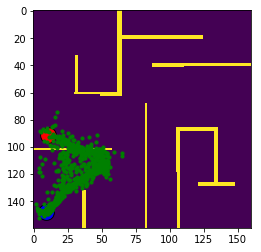

Iter: 411000
Loss: 0.001494

Iter: 412000
Loss: 0.001415

Iter: 413000
Loss: 0.001565

Iter: 414000
Loss: 0.00147

Iter: 415000
Loss: 0.001495

Iter: 416000
Loss: 0.001534

Iter: 417000
Loss: 0.001483

Iter: 418000
Loss: 0.001455

Iter: 419000
Loss: 0.001624

Iter: 420000
Loss: 0.001514



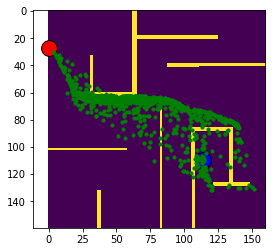

Iter: 421000
Loss: 0.001497

Iter: 422000
Loss: 0.001434

Iter: 423000
Loss: 0.00157

Iter: 424000
Loss: 0.001499

Iter: 425000
Loss: 0.00151

Iter: 426000
Loss: 0.001433

Iter: 427000
Loss: 0.001536

Iter: 428000
Loss: 0.001516

Iter: 429000
Loss: 0.001433

Iter: 430000
Loss: 0.001523



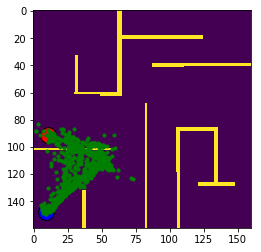

Iter: 431000
Loss: 0.001588

Iter: 432000
Loss: 0.001372

Iter: 433000
Loss: 0.001412

Iter: 434000
Loss: 0.001461

Iter: 435000
Loss: 0.001523

Iter: 436000
Loss: 0.001477

Iter: 437000
Loss: 0.001445

Iter: 438000
Loss: 0.001501

Iter: 439000
Loss: 0.001471

Iter: 440000
Loss: 0.001463



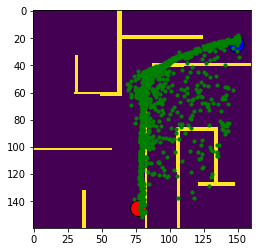

Iter: 441000
Loss: 0.001457

Iter: 442000
Loss: 0.001498

Iter: 443000
Loss: 0.001525

Iter: 444000
Loss: 0.001501

Iter: 445000
Loss: 0.001458

Iter: 446000
Loss: 0.001486

Iter: 447000
Loss: 0.001435

Iter: 448000
Loss: 0.001473

Iter: 449000
Loss: 0.001459

Iter: 450000
Loss: 0.0015



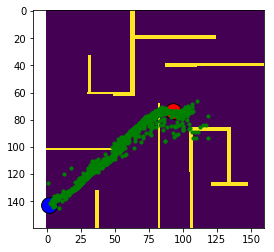

Iter: 451000
Loss: 0.001427

Iter: 452000
Loss: 0.001433

Iter: 453000
Loss: 0.001442

Iter: 454000
Loss: 0.001406

Iter: 455000
Loss: 0.001503

Iter: 456000
Loss: 0.001412

Iter: 457000
Loss: 0.001436

Iter: 458000
Loss: 0.001453

Iter: 459000
Loss: 0.001432

Iter: 460000
Loss: 0.001542



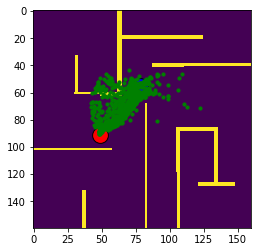

Iter: 461000
Loss: 0.001461

Iter: 462000
Loss: 0.001454

Iter: 463000
Loss: 0.001405

Iter: 464000
Loss: 0.001401

Iter: 465000
Loss: 0.001414

Iter: 466000
Loss: 0.001435

Iter: 467000
Loss: 0.001447

Iter: 468000
Loss: 0.001494

Iter: 469000
Loss: 0.001461

Iter: 470000
Loss: 0.001433



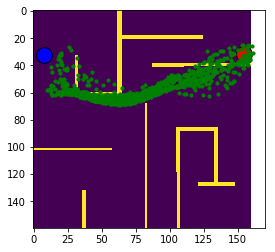

Iter: 471000
Loss: 0.001461

Iter: 472000
Loss: 0.001427

Iter: 473000
Loss: 0.001559

Iter: 474000
Loss: 0.001441

Iter: 475000
Loss: 0.001447

Iter: 476000
Loss: 0.001466

Iter: 477000
Loss: 0.001638

Iter: 478000
Loss: 0.001483

Iter: 479000
Loss: 0.001469

Iter: 480000
Loss: 0.001438



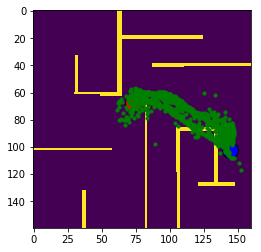

Iter: 481000
Loss: 0.001432

Iter: 482000
Loss: 0.001569

Iter: 483000
Loss: 0.001417

Iter: 484000
Loss: 0.001509

Iter: 485000
Loss: 0.001519

Iter: 486000
Loss: 0.001436

Iter: 487000
Loss: 0.001532

Iter: 488000
Loss: 0.001504

Iter: 489000
Loss: 0.001455

Iter: 490000
Loss: 0.001471



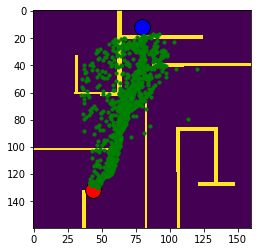

Iter: 491000
Loss: 0.001472

Iter: 492000
Loss: 0.001475

Iter: 493000
Loss: 0.00149

Iter: 494000
Loss: 0.001385

Iter: 495000
Loss: 0.001425

Iter: 496000
Loss: 0.001438

Iter: 497000
Loss: 0.001515

Iter: 498000
Loss: 0.001428

Iter: 499000
Loss: 0.001494



In [10]:
# Train  model and save weights after each ITERS_PER_SAVE
saver = tf.train.Saver()
for i in range(it, TRAIN_ITERS):
    # randomly generate batches
    batch_elements = [randint(0,numTrain-1) for n in range(0,mb_size)]
    X_mb = x_train[batch_elements,:]
    c_mb = cond_train[batch_elements,:]

    _, loss = sess.run([train_step, cvae_loss], feed_dict={X: X_mb, c: c_mb})

    if i % 1000 == 0:
        print('Iter: {}'.format(i))
        print('Loss: {:.4}'. format(loss))
        print()
    if i % ITERS_PER_SAVE == 0:
      saver.save(sess, MODEL_DIR+'/model_for_map%d_iter%d' % (MAP_NUM, i), write_meta_graph=False)
      NUM_SAMPLES = 1000  # number of samples for model to generate
      rand_test_i = randint(0,numTest-1)
      rand_cond = cond_test[rand_test_i, :]
      init = rand_cond[:STATE_DIM] * SAMPLE_SCALE_UP
      goal = rand_cond[STATE_DIM:2*STATE_DIM] * SAMPLE_SCALE_UP

      # same condition repeated NUM_SAMPLES times
      cond_samples = np.repeat([rand_cond],NUM_SAMPLES,axis=0)  

      # directly sample from the latent space to generate predicted samples
      gen_samples, _ = sess.run([y, z], feed_dict={z: np.random.randn(NUM_SAMPLES, z_dim), c: cond_samples})
      # scale up samples to original map dimension
      gen_samples = gen_samples * SAMPLE_SCALE_UP

      plt.imshow(orig_map)
      plt.scatter(x=init[1], y=init[0], color="red", s=250, edgecolors='black') # init
      plt.scatter(x=goal[1], y=goal[0], color="blue", s=250, edgecolors='black') # goal
      plt.scatter(x=gen_samples[:,1], y=gen_samples[:,0], color="green", s=10) # samples

      plt.show()


# Testing 

In [7]:
tf.reset_default_graph()
# Testing initialisation
sess_test = tf.Session()
# sess_test.run(tf.initialize_all_variables())
saver = tf.train.import_meta_graph(MODEL_DIR+'/graph.meta')
saver = tf.train.Saver()
saver.restore(sess_test, tf.train.latest_checkpoint(MODEL_DIR))
# Add code here to load models

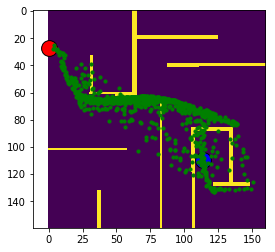

In [9]:

# Now, let's access and create placeholders variables and
# create feed-dict to feed new data
 
NUM_SAMPLES = 1000  # number of samples for model to generate

rand_test_i = randint(0,numTest-1)
rand_cond = cond_test[rand_test_i, :]
init = rand_cond[:STATE_DIM] * SAMPLE_SCALE_UP
goal = rand_cond[STATE_DIM:2*STATE_DIM] * SAMPLE_SCALE_UP

# same condition repeated NUM_SAMPLES times
cond_samples = np.repeat([rand_cond],NUM_SAMPLES,axis=0)  
gen_samples=None
# directly sample from the latent space to generate predicted samples
z = sess_test.graph.get_tensor_by_name('Add:0')
c = sess_test.graph.get_tensor_by_name('c:0')
y = sess_test.graph.get_tensor_by_name('dense_6/BiasAdd:0')
gen_samples, _ = sess_test.run([y, z], feed_dict={z: np.random.randn(NUM_SAMPLES, z_dim), c: cond_samples})
# scale up samples to original map dimension
gen_samples = gen_samples * SAMPLE_SCALE_UP

plt.imshow(orig_map)
plt.scatter(x=init[1], y=init[0], color="red", s=250, edgecolors='black') # init
plt.scatter(x=goal[1], y=goal[0], color="blue", s=250, edgecolors='black') # goal
plt.scatter(x=gen_samples[:,1], y=gen_samples[:,0], color="green", s=10) # samples

plt.show()

In [ ]:
[n.name for n in tf.get_default_graph().as_graph_def().node]

In [4]:
import rospy
from sampling_node.msg import Points
from sampling_node.srv import SamplingService, SamplingServiceResponse, SamplingServiceRequest

ModuleNotFoundError: No module named 'sampling_node'